# Kaggle Titanic Competition

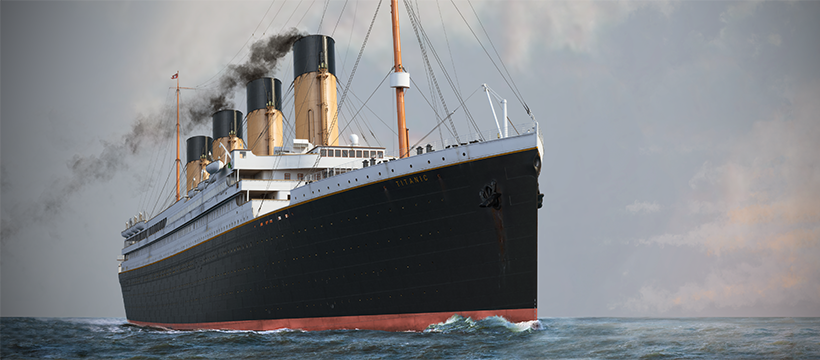



## Introduction

This project outlines a possible take on the Kaggle Titanic Machine Learning competition. The first part explains the data exploration and data cleaning process. Next, new feature 'Family size' is engineered.  Recursive feature elimination and cross-validated selection (RFECV) is then used to select features for the models. Total of 3 models (Logistic regression, K-neighbors Classifier and Random Forrest Classifier), each with a number of hyperparameters is trained and scored. Utilising grid search, Random Forrest Classifier scored the highest of the three with accuracy of 0.83955 on the train set. Using the trained model to predict values of the survival column in the houldout dataset and uploading the resulting values to Kaggle yielded a submission score of 0.76794. 

## Data Loading

The data is divided into two files. The train.csv dataset carries data on passengers plus the survived column (i.e. the ground truth). Machine learning models will be trained on this data. The test.csv dataset contains the same columns as train.csv, however omitting the survived column. A trained model scoring the highest on the train.csv dataset (K-fold cross validation) will be used to predict values of survived column in test.csv. The predicted values will then be submitted to Kaggle.

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [103]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Having a first glance at the data, Age and Cabin columns contain missing values. In order to build a more accurate machine learning model the latter two along with the Fare feature will need to be processed. In addition, titles (Mr., Mrs., Miss.,...) from the Name collumn will be extracted as this will most likely carry valuable information for predicting whether a passenger survived or not.

## Data Exploration and Cleaning

From the movie Titanic we know that women and children were given preference to life boats. According to the movie, the class disparity passenger also played a crucial role.

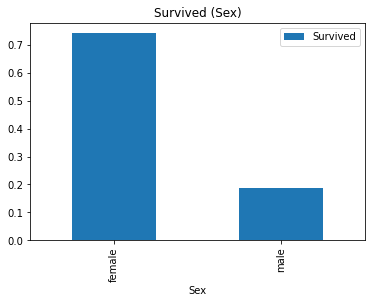

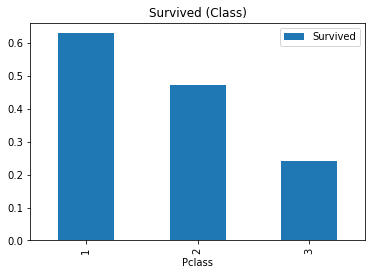

In [104]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.title('Survived (Sex)')
plt.show()

pclass_pivot = train.pivot_table(index = 'Pclass', values = 'Survived')
pclass_pivot.plot.bar()
plt.title('Survived (Class)')
plt.show()

We can see that this was also the case in real life, hence  Sex and Pclass will be considered as important predictors of whether a passenger survived or not. Next we will explore Age however, its values first need to be processed.

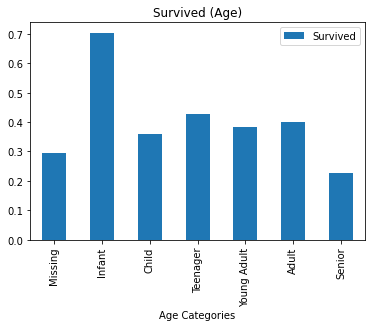

In [105]:
def process_age(df):
    """Process the Age column into pre-defined 'bins'"""
    
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

train = process_age(train)
pivot_train = train.pivot_table(index = 'Age_categories', values = 'Survived')
pivot_train.plot.bar()
plt.xlabel('Age Categories')
plt.title('Survived (Age)')
plt.show()


It is apparent that considerable preference was given to infant children whilst senior passenger were neglected.

Given that Pclass has significant influence on whether a passenger survived, we shall next look at the name column and extract titles. The title of the passenger can be a good indicator of the social class he belonged to, hence be a good predictor. There are total of 18 unique titles, which would result in too many dummy variables. Consequently the feature shall be transformed to contain only 4 unique values.

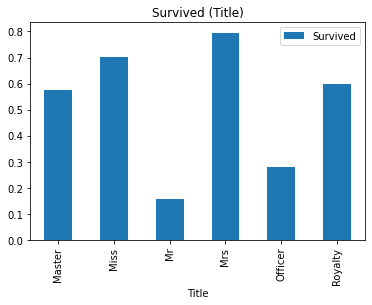

In [106]:
def process_titles(df):
    """Extract and categorize the title from the name column """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

train = process_titles(train)
pivot_train = train.pivot_table(index = 'Title', values = 'Survived')
pivot_train.plot.bar()
plt.title('Survived (Title)')
plt.show()

From the figure above we can see that survival rates for passengers with titles of Mr. and Officer were the lowest especially compared to women. Hence extracting the titles is considered to be worthwhile.

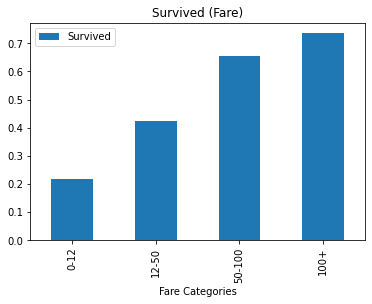

In [107]:
def process_fare(df):
    """Process the Fare column into pre-defined 'bins'"""
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

train = process_fare(train)
pivot_train = train.pivot_table(index = 'Fare_categories', values = 'Survived')
pivot_train.plot.bar()
plt.xlabel('Fare Categories')
plt.title('Survived (Fare)')
plt.show()

It also looks like passengers with the highest fare had the highest chances of survival. 

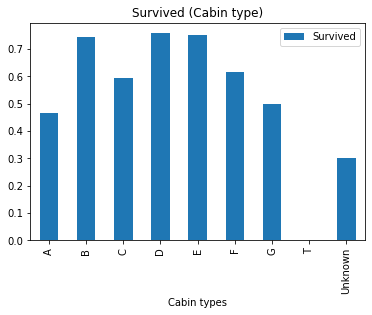

In [108]:
# Similarly we'll process cabin for use in a machine learning model.
def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins'"""
    df["Cabin_type"] = df["Cabin"].str[0] #Extracting only cabin type
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

train = process_cabin(train)
pivot_train = train.pivot_table(index = 'Cabin_type', values = 'Survived')
pivot_train.plot.bar()
plt.xlabel('Cabin types')
plt.title('Survived (Cabin type)')
plt.show()

### Filling MIssing Values

In [109]:
# Processing rest of the missing values
def process_missing(df):
    """Handles rest of the  missing values from the data set """
    
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

train = process_missing(train)


### Creating Dummy Variables For Categorical Features

In [110]:
def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column"""
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
for col in cols:
    train = create_dummies(train, col)

### Transforming the Holdout Dataset

In [111]:
# Transforming columns in the houldout dataset in the same way as the colummns in the train dataset
def process_transform_all(df):
    functions = [process_missing(df), process_age(df), 
                 process_fare(df), process_titles(df), process_cabin(df)]
    for func in functions:
        df = func
    cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in cols:
        df = create_dummies(df, col)
    return df

holdout = process_transform_all(holdout)
    

## Feature Engineering

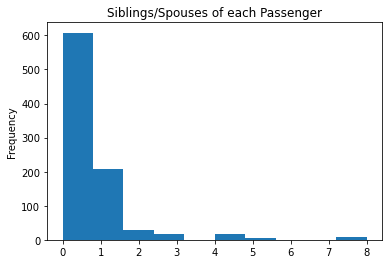

In [112]:
train['SibSp'].plot.hist()
plt.title('Siblings/Spouses of each Passenger')
plt.show()

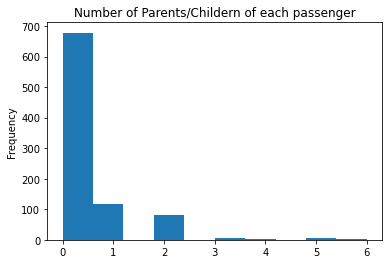

In [113]:
train['Parch'].plot.hist()
plt.title('Number of Parents/Childern of each passenger')
plt.show()

The 'SibSp' column shows the number of siblings/spouses each passenger had on board, whilst 'Parch' contains the number of parents/children of each passenger aboard. Both distributions are highly skewed to the right with majority of values being zero. We can sum these two columns to obtain a new feature 'family size'.

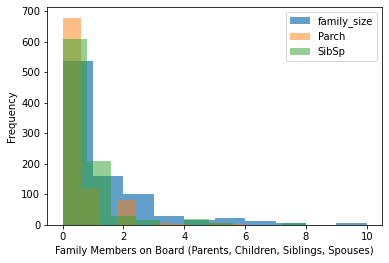

In [114]:
train['family_size'] = train[['SibSp','Parch']].sum(axis = 1)
holdout['family_size'] = holdout[['SibSp','Parch']].sum(axis = 1)

train['family_size'].plot.hist(alpha = 0.7, label = 'family_size', bins = 10)
train['Parch'].plot.hist(alpha = 0.5, label = 'Parch', bins = 10)
train['SibSp'].plot.hist(alpha = 0.5, label = 'SibSp', bins = 10)
plt.xlabel('Family Members on Board (Parents, Children, Siblings, Spouses)')
plt.legend()
plt.show()

The resulting distribution has similar shape, however there are less zero values and the, quantity tapers off less rapidly as the values increase.

Passengers aboard with no family: 537
Only 30.35% survived.


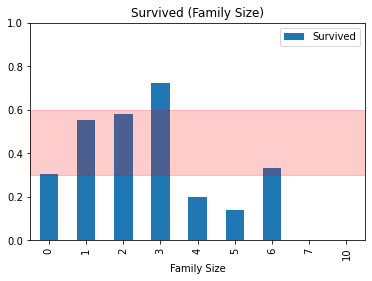

In [115]:
pivoted_family_size = train.pivot_table(index = 'family_size', values = 'Survived')
pivoted_family_size.plot.bar()
plt.axhspan(0.3,0.6, alpha = 0.2, color = 'red')
plt.xlabel('Family Size')
plt.title('Survived (Family Size)')
plt.ylim(0, 1)
plt.plot()

print('Passengers aboard with no family: {}'.format(train[train['family_size'] == 0].count()['family_size']))
print('Only {}% survived.'.format(round(pivoted_family_size.iloc[0][0] * 100, 2)))

Looking at the barplot showing survival rates vs family size we can see that only a handful (30%) of the 537 passengers with no family survived, while significantly higher proportion of passengers with family survived.

In [116]:
def process_isalone(df):
    df['isalone'] = df['family_size'] == 0
    mapper = {True:1, False:0}
    df['isalone'] = df['isalone'].map(mapper)
    df = df.drop('family_size', axis = 1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

## Feature and Model Selection

Instead of selecting features manually, we will use sklearn's recursive feature elimination and cross-validated selection. Logistic regression, K-neighbors Classifier and Random Forrest Classifier models will be trained using a number of different hyperparameters. The best model/hyperparameter combination will be selected utilising grid search.

In [117]:
# Feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Removing non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    #Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.
    selector = RFECV(clf,cv=10) 
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)


Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



In [118]:
#Specifying models with possible hyper parameters and using Grid Search to find model with best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    """Returns a dictionary containig trained models and 
    prints out model name, best score for the model and hyperparameters used to achieve that score"""
    
    all_X = df[features]
    all_y = df['Survived']
    
    models = [{"name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":{"solver": ["newton-cg", "lbfgs", "liblinear"],
                              "max_iter": [200]}},
             {"name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":{"n_neighbors": range(1,20,2),
                               "weights": ["distance", "uniform"],
                               "algorithm": ["ball_tree", "kd_tree", "brute"],
                               "p": [1,2]}},
              {"name": "RandomForrestClassifier",
            "estimator": RandomForestClassifier(random_state = 1),
            "hyperparameters":{"n_estimators": [4, 6, 9],
                               "criterion": ["entropy", "gini"],
                               "max_depth": [2, 5, 10],
                                "max_features": ["log2", "sqrt"],
                               "min_samples_leaf": [1, 5, 8],
                               "min_samples_split": [2, 3, 5]}}]
    
    
    for model in models:
        print(model['name'])
        GS = GridSearchCV(model['estimator'],param_grid = model['hyperparameters'], cv = 10)
        GS.fit(all_X, all_y)
        model['Best_params'] = GS.best_params_
        model['Best_score'] = GS.best_score_
        model['Best_estimator'] = GS.best_estimator_
        
        print('Best Score:{}'.format(model['Best_score']))
        print('Best Parameters:{}'.format(model['Best_params']))
        
    return models

result = select_model(train, cols)

LogisticRegression


/Users/peterzelinka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/peterzelinka/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Best Score:0.8204619225967541
Best Parameters:{'max_iter': 200, 'solver': 'newton-cg'}
KNeighborsClassifier
Best Score:0.7767041198501874
Best Parameters:{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
RandomForrestClassifier
Best Score:0.8395505617977527
Best Parameters:{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}


## Creating a Submission File for Kaggle

In [119]:
def save_submission_file(model, columns, file_name):
    """Creates a new .csv file for submission in a format specified by Kaggle"""
    
    predictions = model.predict(holdout[columns])
    
    submission_df = {'PassengerId': holdout['PassengerId'],
                    'Survived' : predictions}
    submissions = pd.DataFrame(submission_df)
    submissions.to_csv(file_name, index = False)

best_model = result[2]['Best_estimator']
save_submission_file(best_model, cols, 'submission_1.csv')

## Conclusion

To sum up, this project outlined a possible solution for the Kaggle Titanic Machine Learning Competition. The workflow of the project was designed such that it is relatively easy to test different models with various hyperparameters. Features were explored and transformed to allow for use in machine learning. New feature 'Family size', was engineered, with the aim of increasing the accuracy score of the models. Recursive feature elimination and cross-validated selection (RFECV) was employed to select best input features. After that three models, each with number of different hyper parameters were trained and scored. RandomForrest classifier with hyperparameters outlined above scored highest (0.8396) on the train set. The trained model was used to predict values in the survival column of the houldout dataset. Submitting the predictions to Kaggle yielded submission score of 0.76794. To improve the score further it is advised to do more feature engineering.